<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/NLP-Projects/blob/main/Alice-Embedding-Word2Vec-SimilarityAnalysis/alice_embedding_and_similarity_analysis_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install -q gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 45.8 MB/s eta 0:00:00


In [2]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

import nltk
from nltk.corpus import gutenberg
from nltk.tokenize import sent_tokenize

import matplotlib.pyplot as plt
import numpy as np
import logging

from sklearn.decomposition import PCA

# Setup Logging

In [3]:
logging.basicConfig(
    format="%(asctime)s:%(levelname)s:%(message)s", level=logging.INFO
)

# Define Pipeline

In [21]:
class Word2VecPipeline:
    """
    A modular pipeline to load data, preprocess it, train a Word2Vec model,
    evaluate relationships, and visualize the embeddings.
    """
    def __init__(self, config):
        self.config = config
        self.raw_text = None
        self.sentences = []
        self.model = None

        print("Pipeline initialized.")

    def load_data(self):
        """Download and load the raw corpus"""
        print("\n[1/5] Loading Data...")
        try:
            nltk.data.find("corpora/gutenberg")
        except LookupError:
            nltk.download("gutenberg")
            nltk.download("punkt")
            nltk.download("punkt_tab")

        # Load Alice in Wonderland
        self.raw_text = gutenberg.raw("carroll-alice.txt")
        print(f"Data loaded successfully. Corpus length: {len(self.raw_text)}")

    def preprocess_data(self):
        """Preprocess the raw text into sentences and tokens"""
        print("\n[2/5] Preprocessing Data...")
        raw_sentences = nltk.sent_tokenize(self.raw_text)

        self.sentences = []
        for sentence in raw_sentences:
            tokens = simple_preprocess(sentence)
            if len(tokens) > 2:
                self.sentences.append(tokens)

        print(f"Data preprocessed. Total sentences: {len(self.sentences)}")
        print(f"Sample: {self.sentences[0]}")

    def train_model(self):
        """Train a Word2Vec model on the preprocessed data"""
        print("\n[3/5] Training Model...")
        sg_mode = 1 if self.config["architecture"] == "skip-gram" else 0
        self.model = Word2Vec(
            sentences=self.sentences,
            vector_size=self.config['vector_size'],
            window=self.config['window_size'],
            min_count=self.config['min_count'],
            workers=self.config['workers'],
            epochs=self.config['epochs'],
            sg=sg_mode,
            seed=self.config['seed']
        )

        self.model.build_vocab(self.sentences)
        print("Model trained successfully.")
        print(f"Vocabulary size: {len(self.model.wv.index_to_key)}")

    def evaluate(self, test_words):
        """
        Evaluate the model by finding semantically similar words.
        """
        print("\n[4/5] Evaluating Model...")
        for word in test_words:
            if word in self.model.wv:
                print(f"Neighbors for '{word}' are:")
                similar = self.model.wv.most_similar(word, topn=3)
                for w, score in similar:
                    print(f"    {w:<15} - Score: {score:.4f}")
            else:
                print(f"'{word}' not found in the vocabulary.")

    def visualize(self, target_words):
        """
        Visualize the embeddings of target words using PCA.
        """
        print("\n[5/5] Visualizing Model...")
        valid_words = [w for w in target_words if w in self.model.wv]

        if not valid_words:
            print("No Valid words to visualize")
            return

        # Retrieve
        word_vectors = np.array([self.model.wv[w] for w in valid_words])

        # Dimensionality reduction
        pca = PCA(n_components=2)
        result = pca.fit_transform(word_vectors)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.scatter(result[:, 0], result[:, 1], c='teal', s=100, alpha=0.7)

        for i, word in enumerate(valid_words):
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),
                         xytext=(5, 2), textcoords='offset points', fontsize=11)

        plt.title(f"Word Embedding Space (Alice in Wonderland) - {self.config['architecture']}", fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
        print("Visualization displayed.")

    def run(self, eval_words, viz_words):
        """Run the entire pipeline"""
        self.load_data()
        self.preprocess_data()
        self.train_model()
        self.evaluate(eval_words)
        self.visualize(viz_words)

# Run Pipeline

Pipeline initialized.

[1/5] Loading Data...
Data loaded successfully. Corpus length: 144395

[2/5] Preprocessing Data...
Data preprocessed. Total sentences: 1484
Sample: ['alice', 'adventures', 'in', 'wonderland', 'by', 'lewis', 'carroll', 'chapter']

[3/5] Training Model...


Model trained successfully.
Vocabulary size: 1041

[4/5] Evaluating Model...
Neighbors for 'alice' are:
    adventures      - Score: 0.8049
    chapter         - Score: 0.7343
    in              - Score: 0.6765
Neighbors for 'queen' are:
    which           - Score: 0.5520
    does            - Score: 0.5294
    this            - Score: 0.5184
Neighbors for 'rabbit' are:
    by              - Score: 0.7034
    down            - Score: 0.6730
    wonderland      - Score: 0.6610
Neighbors for 'tea' are:
    hoping          - Score: 0.4628
    cheshire        - Score: 0.4573
    cautiously      - Score: 0.4567
Neighbors for 'king' are:
    together        - Score: 0.5816
    subject         - Score: 0.5753
    slipped         - Score: 0.5411

[5/5] Visualizing Model...


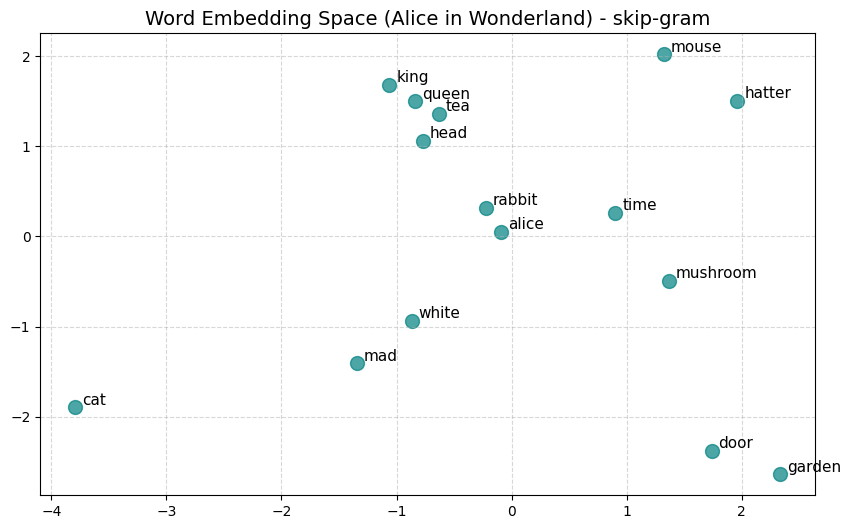

Visualization displayed.


In [24]:
# Hyperparameters configuration
config = {
    'vector_size': 64,       # Dimensionality of the word vectors
    'window_size': 5,        # Maximum distance between the current and predicted word
    'min_count': 3,          # Ignores all words with total frequency lower than this
    'workers': 4,            # Number of worker threads
    'epochs': 150,            # Number of iterations over the corpus
    'architecture': 'skip-gram', # 'skip-gram' or 'cbow'
    'seed': 42,              # Seed for reproducibility
    'min_token_length': 3    # Minimum length of words to keep during preprocessing
}

# Define words for evaluation and visualization
evaluation_words = ['alice', 'queen', 'rabbit', 'tea', 'king']
visualization_words = [
    'alice', 'queen', 'king', 'rabbit', 'cat', 'hatter', 'tea', 'mouse',
    'garden', 'door', 'mushroom', 'head', 'time', 'white', 'mad'
]

# Instantiate and run the pipeline
pipeline = Word2VecPipeline(config)
pipeline.run(evaluation_words, visualization_words)